# Indonesian Contraceptive Choice

### Imports

In [108]:
import importlib
import matplotlib.pyplot as plt

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myskutils
importlib.reload(mysklearn.myskutils)
import mysklearn.myskutils as myskutils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import copy
import pickle

# Introduction
## Introduction to the Dataset
This Jupyter Notebook gives a storied detailed analysis on data mining and classification done on the dataset found from this link https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice. This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey, which samples about 1500 Indonesian women who are either not pregnant at the time of the interview or don't know they are. The list below shows the attributes stored in the dataset and were asked by the interviewer:

1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

## Introduction to Classification
The goal of this project was to try and classify the contraceptive method used based on certain attributes that seemed to have a high correlation  to the contraceptive method used. In order to do so, we implemented our own KNN Classifier, Naive Bayes Classifier, and Random Forest Classifier. What we found was that our KNN Classifier gave the best total accuracy in predicting the contraceptive method used, while our Naive Bayes Classifier and Random Forest Classifier didn't perform as well. 



# Data Analysis
### Opening Dataset

In [3]:
cont_data_fname = os.path.join("input_data", "contraception_data.csv")
header1,table1 = myutils.create_data(cont_data_fname)
data = MyPyTable(data=table1, column_names=header1)
data.convert_to_numeric()


### Cleaning Data

In [4]:
# subsituiting number of contraceptive use to actual name
for i in range(len(data.data)):
    if (data.data[i][9] == 1):
        data.data[i][9] = "no use"
    elif (data.data[i][9] == 2):
        data.data[i][9] = "long-term"
    else:
        data.data[i][9] = "short-term"

    

## Generating Graph to Demonstrate Class Variable Frequency

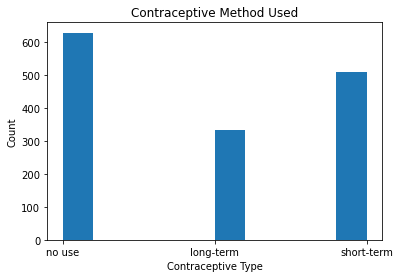

In [5]:
method_used = data.get_column("contraceptive method used")
plot_utils.histogram(method_used, "Count", "Contraceptive Type", "Contraceptive Method Used", 3)


### Notes on Figure #1
This frequency diagram shows how the class labels are distributed in the dataset. As you can see, there isn't a class label that is overwhelmingly frequent over the others, although there is definately a class inbalance between the three classes. Therefore this must be noted in analyzing the dataset and interpretating the classification results for each classifier. 

## Generating Frequency Diagram for each Contraceptive Method used Based on Total Number of Kids


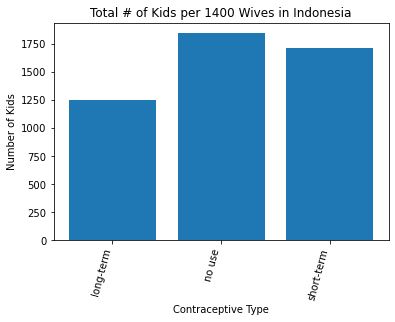

In [6]:
children_born = data.get_column("number of children")
group_names, group_subtables = myutils.group_by(data.data, 9)
sums = []
for i in range(len(group_subtables)):
    col = myutils.get_column(group_subtables[i], 3)
    nums = sum(col)
    sums.append(nums)

plot_utils.bar_chart2(group_names,sums,"Number of Kids","Contraceptive Type","Total # of Kids per 1400 Wives in Indonesia")



    



### Notes on Figure #2
As demonstrated in the chart above, there is definitely a correlation between the contraceptive method used and the total number of kids born. As expected, women with no use of a contraceptive method tend to have more kids, while woman with a long-term contraceptive method tend to have less kids. This diagram helps us identify the 'total number of kids' attribute as an important attribute in classifying the contraceptive type and should help us learn something from our classification results.  
  

## Generating Pie Charts to Compare Contraceptive Method Distributions Depending on Standard of Living Index

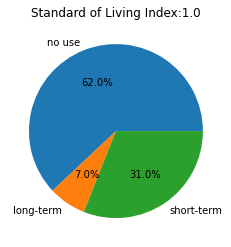

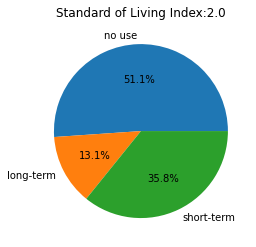

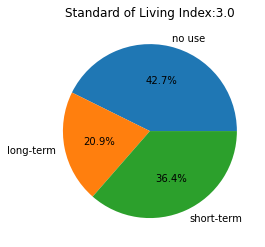

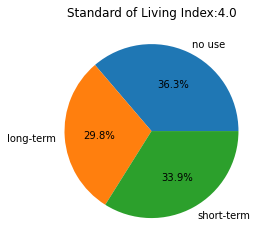

In [7]:
group_names, group_subtables = myutils.group_by(data.data, -3)
labels = ["no use", "long-term", "short-term"]
count = 0
for group in group_subtables:
    counts = [0, 0, 0]
    for instance in group:
        if instance[-1] == "no use":
            counts[0] += 1
        if instance[-1] == "long-term":
            counts[1] += 1
        if instance[-1] == "short-term":
            counts[2] += 1
    plot_utils.pie_chart(labels, counts, "Standard of Living Index:" + str(group_names[count]))
    count+=1

### Notes on Pie Charts:
As demonstrated in the pie charts, as the standard of living increases, the number of women with a no-use contraceptive method decrease, and the number of women using a long-term contraceptive method increase. This demonstrates a strong correlation between the standard of living index and contraceptive method used, which identifies the 'standard of living index' attribute as another important attribute in classifying the correct contraceptive type. 

## Wife's Age and Contraceptive Method

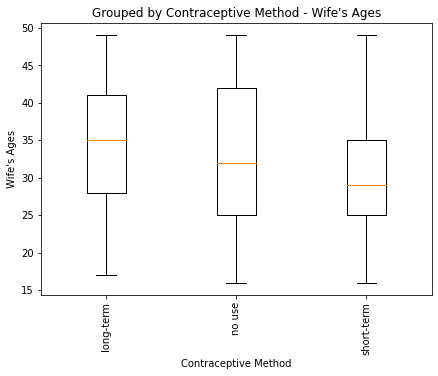

In [8]:
group_names, group_subtables = myutils.group_by(data.data, -1)

ages_grouped_by_method = [[] for i in range(len(group_names))]

for i in range(len(group_subtables)):
    for instance in group_subtables[i]:
        ages_grouped_by_method[i].append(instance[0])

plot_utils.box_plot(ages_grouped_by_method, group_names, "Contraceptive Method", "Wife's Ages", "Grouped by Contraceptive Method - Wife's Ages")

### Notes on Figure #4
Looking at the figure above, there doesn't seem to be too much differenciation between the mean ages of the three box plots generated. Although something to note is that the ages for wives using a long-term contraceptive method seem to be higher than wives using a short-term contraceptive method. Overall, the wide-spread box plot for the no-use contraceptive and the similar means across the plots, tell us that the 'wife's age' attribute may not be very affective at increasing the accuracy of our classifiers.

# Classification Results

As mentioned previously, we created a kNN, Naive Bayes, and Random Forest Classifier to predict the contraceptive type of unseen instances. For each classifier, we 'played around' to find out which attributes were helpful in determining the correct class label. After we identified these helpful attributes, they were utilized to train each model. While each classifier had around the same accuracy, the Naive Bayes classifier proved to be the most accurate and was used for the model deployment portion of this assignment.

## KNN Classification

In [9]:
X = []
y = []
for i in range(len(data.data)):
    a_list = []
    a_list.append(data.data[i][0]) # high correlation
    a_list.append(data.data[i][1]) # high correlation
    a_list.append(data.data[i][2])
    a_list.append(data.data[i][3]) # high correlation
    #a_list.append(data.data[i][4])
    #a_list.append(data.data[i][5])
    a_list.append(data.data[i][6]) # high correlation
    #a_list.append(data.data[i][7])
    #a_list.append(data.data[i][8])
    X.append(a_list)
    y.append(data.data[i][9])


In [10]:
knn_classifier = MyKNeighborsClassifier()


In [11]:
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X, y, test_size=0.33, random_state=None, shuffle=True)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
acc = myskutils.get_accuracy(predictions, y_test)
print("kNN Accuracy:", acc)

kNN Accuracy: 0.49075975359342916


In [12]:
labels = ["no use", "short-term","long-term"]
knn_matrix = myevaluation.confusion_matrix(y_test,predictions,labels)
print("KNN Classifier Results:")
print("-------------------------------------------------------------")
myskutils.print_matrix(knn_matrix, labels, "Contraceptive type")
print()

KNN Classifier Results:
-------------------------------------------------------------
Contraceptive type      no use    short-term    long-term    Total    Recognition
--------------------  --------  ------------  -----------  -------  -------------
no use                     113            44           48      205        55.122
short-term                  36            80           58      174        45.977
long-term                   26            36           46      108        42.5926



For the kNN Classifier, we discovered that five attributes were informative in predicting the correct contraceptive label: the wife's age, her education level, number of children in the family, the husband's education level, as well as his occupation. After training the classifier with these attributes, we reached a peak accuracy of roughly fifty percent. Considering that we have three class labels, and even taking into account the somewhat 'unevenness' of our class distribution, this classifier is still performing better than random. In particular, after looking at the confusion matrix above, it is evident that the classifier is best at predicting the 'no use' contraceptive method, which is understandable since there are more of these instances in the dataset. 

## Naive Bayes Classification

In [113]:

bayes = MyNaiveBayesClassifier()

In [114]:
X = []
y = []
for i in range(len(data.data)):
    a_list = []
    a_list.append(data.data[i][0]) # high correlation
    a_list.append(data.data[i][1]) # high correlation
    # a_list.append(data.data[i][2])
    a_list.append(data.data[i][3]) # high correlation
    #a_list.append(data.data[i][4])
    #a_list.append(data.data[i][5])
    a_list.append(data.data[i][6]) # high correlation
    #a_list.append(data.data[i][7])
    #a_list.append(data.data[i][8])
    X.append(a_list)
    y.append(data.data[i][9])

In [115]:
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X, y, test_size=0.33, random_state=None, shuffle=True)

In [116]:
bayes.fit(X_train, y_train)
predictions = bayes.predict(X_test) 

In [117]:
outfile = open("bayes.p", "wb")
pickle.dump(bayes, outfile)
outfile.close()

In [118]:
accuracy = myskutils.get_accuracy(predictions, y_test)
print("Naive Bayes Classification Accuracy:", accuracy) 

Naive Bayes Classification Accuracy: 0.4928131416837782


In [119]:
naive_matrix = myevaluation.confusion_matrix(y_test,predictions,labels)
print("Naive Bayes Classifier:")
print("-------------------------------------------------------------")
myskutils.print_matrix(naive_matrix, labels, "Contraceptive type")
print()

Naive Bayes Classifier:
-------------------------------------------------------------
Contraceptive type      no use    short-term    long-term    Total    Recognition
--------------------  --------  ------------  -----------  -------  -------------
no use                     119            72           21      212        56.1321
short-term                  43            74           40      157        47.1338
long-term                   25            46           47      118        39.8305



Overall, the Naive Bayes Classifier performed the most accurately when compared to our other classification attempts. Like the kNN Classifier, the Naive Bayes model utilizes the wife's age and education, as well as the number of children in the family and the husband's occupation to make predictions. Again, like the kNN Classifier, the recognition rate for the 'no use' class label is relatively greater than the others, an inevitable consequence of the class distribution. This was the model we used for the model deployment portion of this assignment. 

## Random Forest Classifier

In [22]:
forest = MyRandomForestClassifier()

In [23]:
X = []
y = []
for i in range(len(data.data)):
    a_list = []
    a_list.append(data.data[i][0]) # high correlation
    a_list.append(data.data[i][1]) # high correlation
    a_list.append(data.data[i][2]) # high correlation
    a_list.append(data.data[i][3]) # high correlation
    #a_list.append(data.data[i][4])
    #a_list.append(data.data[i][5])
    a_list.append(data.data[i][6]) # high correlation
    #a_list.append(data.data[i][7])
    #a_list.append(data.data[i][8])
    X.append(a_list)
    y.append(data.data[i][9])

In [24]:
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X, y, test_size=0.33, random_state=None, shuffle=True)

In [25]:
forest.fit(X_train, y_train)
predictions = forest.predict(X_test) 

In [26]:
accuracy = myskutils.get_accuracy(predictions, y_test)
print("Random Forest Classification Accuracy:", accuracy) 

Random Forest Classification Accuracy: 0.4928131416837782


In [54]:
forest_matrix = myevaluation.confusion_matrix(y_test,predictions,labels)
print("Random Forest Classifier:")
print("-------------------------------------------------------------")
myskutils.print_matrix(forest_matrix, labels, "Contraceptive type")
print()

Random Forest Classifier:
-------------------------------------------------------------
Contraceptive type      no use    short-term    long-term    Total    Recognition
--------------------  --------  ------------  -----------  -------  -------------
no use                     119            48           30      197        60.4061
short-term                  54            80           42      176        45.4545
long-term                   22            41           51      114        44.7368



# Conclusion

Overall, this project certainly provided some insight regarding the factors that can affect contraceptive choices in certain regions, particularly in Indonesia. As we discovered, the wife's occupation and age, along with her husband's education and occupation, and the number of children in the family are informative factors that affect a family's contraceptive method. 

Luckily, our dataset was easy to work with, as there were no inherent cleaning issues that had to be resolved. However, our classifiers were not as accurate as hoped, with accuracies that only suggest slightly more informative than guessing at random. Nonetheless, we were able to explore several relationships between the attributes through the exploratory data analysis portion of this assignment. To improve our classifiers for future prediction efforts, we could try to use an ensemble learning method of classification.